In [31]:
%matplotlib inline

import os
import sys
import cv2
import yaml
import torch
import torchvision
from torchvision.ops.boxes import masks_to_boxes

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [32]:
sys.path.append('../../../')

%load_ext autoreload
%autoreload 2

    
from video_processing.yolov7.dataset.utils import read_image, inverse_image_n_boxes_to_target_size, image_n_boxes_to_target_size
from video_processing.misc import alpha_bending
from video_processing.yolov7.dataset.coords import xyxy2xywh, xywh2xyxy, normalized_xywh2xyxy
from video_processing.yolov7.dataset.modification import random_affine, augment_hsv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
class PennFudanDataset(torch.utils.data.Dataset):

    def __init__(self, root, image_dirname, mask_dirname, hyp, indices=None, img_size=1280, augment=False, correct_exif=True,
                 padding_value=(114,114,114)):
        '''
        Input:
            root (str): path to data folder
            image_dirname (str): name of subfolder containing images
            mask_dirname (str): name of subfolder containing masks
            hyp (dict): hyperparameters for data augmentation
            indices (sequence): indices to data used
        '''
        self.augment=augment
        self.img_size=img_size
        self.hyp=hyp
        self.correct_exif=correct_exif
        self.padding_value=padding_value
        self.image_dirpath=os.path.join(root, image_dirname).encode('utf-8')
        self.mask_dirpath=os.path.join(root, mask_dirname).encode('utf-8')

        self.image_fnames=np.asarray(sorted(s.encode('utf-8') for s in os.listdir(self.image_dirpath.decode('utf-8')))) # decode s.decode('utf-8')
        self.mask_fnames=np.asarray(sorted(s.encode('utf-8') for s in os.listdir(self.mask_dirpath.decode('utf-8')))) # decode s.decode('utf-8')
        if indices is None: indices=np.arange(len(self.image_fnames))
        if max(indices)<len(self.image_fnames):
            self.image_fnames=[self.image_fnames[idx] for idx in indices]
            self.mask_fnames=[self.mask_fnames[idx] for idx in indices]

        # make sure that files are ordered consistently
        for im, msk in zip(self.image_fnames, self.mask_fnames):
            im=im.decode('utf-8')
            msk=msk.decode('utf-8')
            assert all(os.path.splitext(im)[0]==os.path.splitext(x)[0].replace('_mask', '') for x in [msk])

    def __len__(self):
        return len(self.image_fnames)

    def __getitem__(self, idx):

        idx=idx%len(self.image_fnames)

In [34]:
hyperparam_file='hyp.scratch.p6.yaml'
with open(hyperparam_file) as f: hyp=yaml.load(f, Loader=yaml.SafeLoader)
    
root='D:/data/PennFudanPed'
dataset=PennFudanDataset(root=root, image_dirname='PNGImages', mask_dirname='PedMasks', hyp=hyp, indices=None, 
                        img_size=1280, augment=True, correct_exif=True,padding_value=(114,114,114))

In [35]:
idx=0

image_fpath=os.path.join(dataset.image_dirpath.decode('utf-8'), dataset.image_fnames[idx].decode('utf-8'))
mask_fpath=os.path.join(dataset.mask_dirpath.decode('utf-8'), dataset.mask_fnames[idx].decode('utf-8'))


image,(H0,W0)=read_image(image_fpath, target_size=dataset.img_size, correct_exif=dataset.correct_exif)
mask,_=read_image(mask_fpath, target_size=dataset.img_size, correct_exif=dataset.correct_exif, mode='nearest')

## --- determine class-index, image-index, bounding boxes in x1,y1,x2,y2 format in pixel unit
mask=torch.from_numpy(mask)[None] # CxHxW -> CxYxX
# instances are encoded with different colors
obj_ids=torch.unique(mask)
# first id is the background, so remove it
obj_ids=obj_ids[1:]
n_objs=len(obj_ids)
# first we split the color-encoded mask into a set of binary masks
masks=(mask==obj_ids[:,None,None]).to(dtype=torch.uint8) # LxHxW or LxYxX where L is the number of objects
class_idx=torch.ones(n_objs,dtype=torch.long)[:,None] # Nx1 where N is the number of boxes. Note there is only 1 class
image_id=torch.tensor([idx]).repeat(n_objs)[:,None] # Nx1
boxes=masks_to_boxes(masks) # Nx4 where N is the number of objects and 4 for x-min,y-min,x-max,y-max

## --- adjust image and boxes to target size. We actually can start by operating on mask and then get boxes from mask
# but we implement this way in case, for some data, we do not have masks
adjusted_image, ratio, (shift_x, shift_y)=image_n_boxes_to_target_size(image, boxes, target_size=dataset.img_size, scale_up=True, color=(114,114,114), eps=1.e-4)


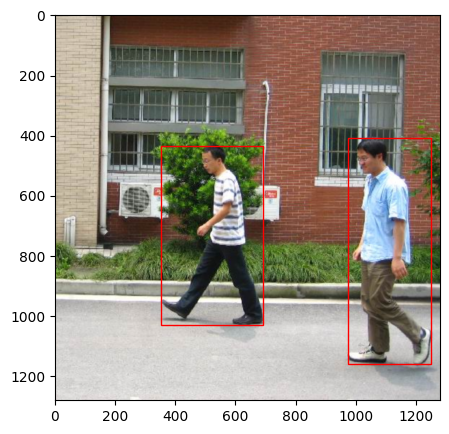

In [36]:

_, ax=plt.subplots(figsize=(10,5))
ax.imshow(adjusted_image)
boxes_=boxes #normalized_xywh2xyxy(boxes, w=mask.shape[-1], h=mask.shape[-2])
for box in boxes_:
    rect = patches.Rectangle(box[:2], *(box[2:]-box[:2]), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

targets  torch.Size([2, 5])


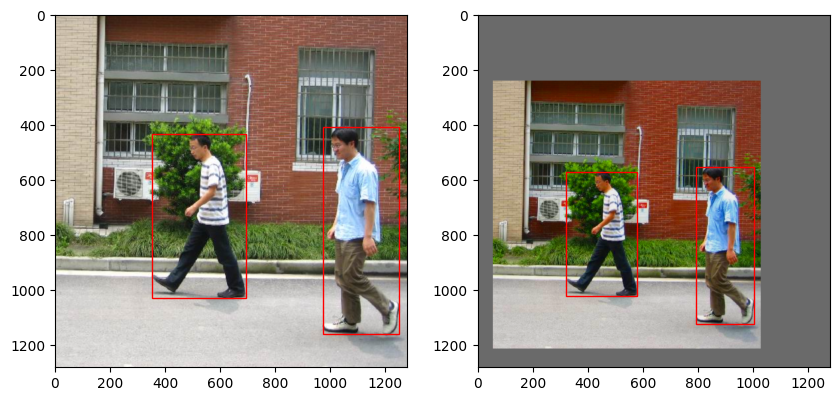

In [37]:
if dataset.augment:
    # we should have just passed the boxes but since we already have this function from yolov7 which was written first for coco
    # we are just going to format the targets and pass them to the function
    targets=torch.cat([class_idx, boxes], dim=-1)
    print('targets ', targets.shape)
    img,targets=random_affine(img=adjusted_image, targets=targets.numpy(), degrees=dataset.hyp['degrees'], translate=dataset.hyp['translate'], 
                             scale=dataset.hyp['scale'], padding_value=dataset.padding_value)
    img=augment_hsv(img, hgain=dataset.hyp['hsv_h'],sgain=dataset.hyp['hsv_s'],vgain=dataset.hyp['hsv_v'])
    
    _, ax=plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(adjusted_image)
    for box in boxes:
        rect = patches.Rectangle(box[:2], *(box[2:]-box[:2]), linewidth=1, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
    ax[1].imshow(img)
    boxes_=targets[:,1:] #normalized_xywh2xyxy(boxes, w=mask.shape[-1], h=mask.shape[-2])
    for box in boxes_:
        rect = patches.Rectangle(box[:2], *(box[2:]-box[:2]), linewidth=1, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)


    boxes=targets[:,1:]

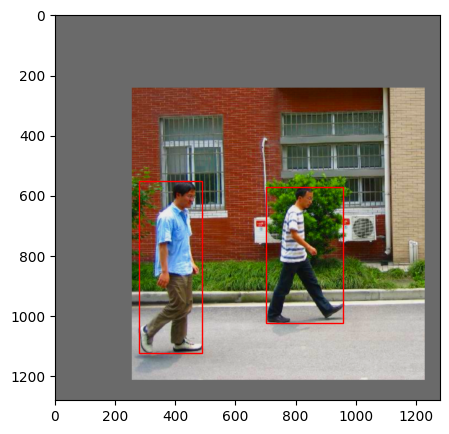

In [38]:
if len(boxes)>0:
    # convert x1,y1,x2,y2 in pixel unit to x,y,w,h where (x,y) is the center of box and (w,h) is width and height
    boxes=xyxy2xywh(boxes)
    # normalize so width and height is between 0-1
    boxes[:,[0,2]]/=img.shape[1] # normalize x direction by width
    boxes[:,[1,3]]/=img.shape[0] # normalize y direction by height

if dataset.augment:
    if np.random.rand()<dataset.hyp['flipud']: # flip up down
        img=np.flipud(img)
        if len(boxes)>0: boxes[:,1]=1-labels[:,1]
    if np.random.rand()<dataset.hyp['fliplr']: # flip left right
        img=np.fliplr(img)
        if len(boxes)>0: boxes[:,0]=1-boxes[:,0]

_, ax=plt.subplots(figsize=(10,5))
ax.imshow(img)
dn_boxes=normalized_xywh2xyxy(boxes, w=img.shape[1], h=img.shape[0])
for box in dn_boxes:
    rect = patches.Rectangle(box[:2], *(box[2:]-box[:2]), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

array([[306.84116, 445.0281 , 439.10815, 676.6981 ],
       [548.2488 , 434.88498, 655.76636, 727.8198 ]], dtype=float32)

array([[0.29138646, 0.43817434, 0.10333359, 0.18099225],
       [0.4703184 , 0.45418158, 0.08399816, 0.22885537]], dtype=float32)

In [28]:
normalized_xywh2xyxy?

Signature: normalized_xywh2xyxy(x, w=None, h=None, shift_x=0.0, shift_y=0.0)
Docstring:
Convert [x,y,w,h] where (x,y) is the center of boxes and (w,h) is width and height to
[x1,y1,x2,y2] where (x1,y1) is the top-left corner and (x2,y2) is the bottom right corner
Args:
    x (ndarray/Tensor): Nx4 where N is the number of boxes and 4 for [x,y,w,h] with/without normalization
    w (int/float): width of the original image where the bounding box was annotated, used to denormalized input x,
        where pixel indices are normalized by width and height so they range from [0,1]. If None, x is defined in pixel units
    h (int/float): height of the original image where the bounding box was annotated, used to denormalized input x,
        where pixel indices are normalized by width and height so they range from [0,1]. If None, x is defined in pixel units
    shift_x (int/float): translation of the boxes along x axis
    shift_y (int/float): translation of the boxes along y axis 
Returns:
    y

In [9]:

# boxes=xyxy2xywh(boxes) # Nx4 where N is the number of objects and 4 for x-center, y-center, width, height
# # normalized boxes by image width and height so every term is the range 0-1
# boxes[:,[0,2]]/=mask.shape[-1]
# boxes[:,[1,3]]/=mask.shape[-2]

# labels=torch.cat((image_id, class_idx, boxes), dim=-1)
# labels.shape, labels